マクロ初期値依存性を見てみよう．

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import os, sys, copy
import re, glob

In [3]:
%load_ext autoreload
# リロードしたいときは %autoreload で

In [4]:
from chainer import Chain, ChainList, cuda, gradient_check, Function, Link, optimizers, serializers, utils, Variable, datasets, using_config
from chainer import functions as F
from chainer import links as L

import scipy.special as spsp
class Func_erf2(Function): # (erf(x/sqrt(2)))   
    def forward_cpu(self, x):
        sq2 = x[0].dtype.type(np.sqrt(2.0))
        self.y = utils.force_array(spsp.erf(x[0]/sq2))
        return self.y,
    def backward_cpu(self, x, gy):
        sq2pi = x[0].dtype.type(np.sqrt(2.0/np.pi))
        two = x[0].dtype.type(2.0)
        return utils.force_array(gy[0]*sq2pi*np.exp(-x[0]*x[0]/two)),
def func_erf2(x):
    return Func_erf2()(x)

def is_integer_type(typ):
    try:
        xp = cuda.cupy
        return typ in [int, np.int, np.int8, np.int16, np.int32, np.int64,
                np.uint, np.uint8, np.uint16, np.uint32, np.uint64,
                xp.int8, xp.int16, xp.int32, xp.int64,
                xp.uint8, xp.uint16, xp.uint32, xp.uint64,]
    except AttributeError:
        return typ in [int, np.int, np.int8, np.int16, np.int32, np.int64,
                np.uint, np.uint8, np.uint16, np.uint32, np.uint64]



class MLP(ChainList):
    def __init__(self, ls, nobias, act, opt):
        self.ls = ls
        self.l = []
        for i in range(len(ls)-1):
            self.l.append(L.Linear(ls[i], ls[i+1], nobias=nobias))
        super(MLP, self).__init__(*self.l)
        self.act = act
        self.opt = opt
        if self.opt is not None: self.opt.setup(self)
        self.lossfrac = np.zeros(2)
        self.accfrac = np.zeros(2)
    def __call__(self, x, mode='train'): # Variable受け取ってVariable返す
        with using_config('train', mode=='train'):
            for i in range(len(self.l)):
                x = self.l[i](x)
                if (i+1<len(self.l)): x = self.act(x)
        return x
    def update(self, x, t, mode='train'):  # Variable受け取ってVariable返す
        bs = x.shape[0]
        y = self(x, mode=mode)
        if is_integer_type(t.data.dtype):
            if 1: # 分類 (softmax_cross_entropy)
                loss = F.softmax_cross_entropy(y, t)
                acc = np.count_nonzero(np.argmax(y.data,axis=1)==t.data)
            elif 0: # 二値分類 (sigmoid_cross_entropy)
                loss = F.sigmoid_cross_entropy(y, t) # y and t has same dimension
                acc = np.count_nonzero((y.data>0).astype(np.int32)==t.data)
            else:
                raise ValueError
        else:
            # 回帰 (squared)
            loss = 0.5 * F.sum((y - t)**2) / bs
            acc = 0

        # loss は bs で割られたスカラーになっている．はず
        if mode=='train':
            self.cleargrads()
            loss.grad = np.ones(loss.shape, dtype=np.float32)
            loss.backward()
            self.opt.update()
        elif mode=='test':
            pass
        else:
            raise ValueError
        self.lossfrac += np.array([np.sum(loss.data) * bs, bs])
        self.accfrac += np.array([acc, bs])
        return loss
    def aveloss(self, clear=False):
        ret = self.lossfrac[0]/self.lossfrac[1]
        if clear: self.lossfrac = np.zeros(2)
        return ret
    def aveacc(self, clear=False):
        ret = (0.+self.accfrac[0])/self.accfrac[1]
        if clear: self.accfrac = np.zeros(2)
        return ret
    def W(self, idx):
        return self.l[idx].W.data

In [5]:
def retain_random_state(func):
    def wrapper(*args, **kwargs):
        random_state = np.random.get_state()
        func(*args, **kwargs)
        np.random.set_state(random_state)
    return wrapper

In [6]:
def average(ary, bin_width):
    return np.array([np.mean(ary[i:i+bin_width]) for i in range(0,len(ary),bin_width)])

In [7]:
def overlap(v1, v2):
    return np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)

In [8]:
def get_mnist_lambdas():
    train, test = datasets.get_mnist()
    ary = np.array([data[0] for data in train]).astype(np.float64) # (60000, 784)
    return np.sort(np.linalg.svd(ary, compute_uv=False) ** 2) / ary.shape[0]
mnist_lambdas = get_mnist_lambdas()

In [9]:
def name2idx(s):
    if s[:6]=='setosa': return 0
    elif s[:10]=='versicolor': return 1
    else: return 2
def get_iris_data():
    with open('iris.csv', 'r') as f:
        lines = f.readlines()
    data = []
    for line in lines[1:]:
        datum = line.split(',')
        data.append((np.array(list(map(float, datum[:4]))), name2idx(datum[4])))
    return data
def get_iris_lambdas():
    train = get_iris_data()
    ary = np.array([data[0] for data in train]).astype(np.float64) # (150, 4)
    return np.sort(np.linalg.svd(ary, compute_uv=False) ** 2) / ary.shape[0]
iris_lambdas = get_iris_lambdas()

In [10]:
def show_lambda_statistics(lambdas):
    print('lambdas:', lambdas[:5], '...', lambdas[-5:])
    print('<lambda>', np.mean(lambdas))
    print('<lambda**2>', np.mean(lambdas**2))
    print('<lambda**4>', np.mean(lambdas**4))
    print('<lambda**2>/<lambda>', np.mean(lambdas**2)/np.mean(lambdas))
    print('sqrt(<lambda**4>/<lambda**2>)', np.sqrt(np.mean(lambdas**4)/np.mean(lambdas**2)))
    print('overlap of lambdas and lambdas**2:  ', overlap(lambdas, lambdas**2))


In [11]:
N = 100

In [12]:
import order_parameter_dynamics as opd

In [13]:
def calc_opd(N, nb_iter, lambdas, eta, K=2, M=2, act='erf', nQRT=None, nABC=None, mdl=None, mdl_t=None, ignore_etasq=[False, True], slowing=1.0, verbose=True, goal_loss=None):

    if mdl is not None:
        tmp_mdl = mdl
    else:
        tmp_mdl = MLP(ls=[N,K,1], nobias=True, act=func_erf2, opt=optimizers.SGD(lr=eta/N))    
        tmp_mdl.l[1].W.data = np.ones([1, K]).astype(np.float32)
    
    if mdl_t is not None:
        tmp_mdl_t = mdl_t
    else:
        tmp_mdl_t = MLP(ls=[N,M,1], nobias=True, act=func_erf2, opt=None)
        tmp_mdl_t.l[1].W.data = np.ones([1, M]).astype(np.float32)

    assert(len(np.unique(lambdas[np.nonzero(lambdas)])) == 1) # 非ゼロ相異なる固有値は１個を家庭
    ncov = np.diag(lambdas)
    # ncov = np.diag([1] * N)

    if nQRT is None:
        _ = np.r_[tmp_mdl.W(0), tmp_mdl_t.W(0)]
        nQRT = np.dot(np.dot(_, ncov), _.T)
    print('nQRT:', nQRT)
    if nABC is None:
        _ = np.c_[tmp_mdl.W(1), tmp_mdl_t.W(1)]
        nABC = np.dot(_.T, _)
    print('nABC:', nABC)

    ncovncov = np.dot(ncov, ncov)
    nT4 = np.dot(np.dot(tmp_mdl_t.W(0), np.dot(ncovncov, ncovncov)), tmp_mdl_t.W(0).T)
    nT2 = np.dot(np.dot(tmp_mdl_t.W(0), ncovncov), tmp_mdl_t.W(0).T)
    nT1 = np.dot(np.dot(tmp_mdl_t.W(0), ncov), tmp_mdl_t.W(0).T)
    print('sqrt(nT4/nT2): ', np.sqrt(nT4/nT2))
    print('nT2/nT1: ', nT2/nT1)
    QRTcoef = np.array([np.sqrt(nT4/nT2)[0,0], nT2[0,0]])

    QRTcoef *= slowing
    if slowing != 1: print('!! slowing:', slowing)

    print('QRTcoef: ', QRTcoef)

    op = opd.opd_inf_KM_inf(nQRT, nABC, K=K, M=M, eta=eta, act=act, ignore_etasq=ignore_etasq, QRTcoef=QRTcoef, ABCcoef=[0]) # ABCcoef=[0] は soft-committee にするため
    # nb_iter = 1000
    print('nb_iter:', nb_iter)

    opQRT = np.zeros([nb_iter+1,K+M,K+M]) + np.nan
    # opABC = np.zeros([nb_iter+1,K+M,K+M]) + np.nan
    opL = np.zeros([nb_iter+1]) + np.nan
    opQRT[0,:,:] = op.QRT.copy()
    opL[0] = op.eps()

    
    for it in tqdm(range(nb_iter)) if verbose else range(nb_iter):
        op.update()
        opQRT[1+it,:,:] = op.QRT.copy()
        opL[1+it] = op.eps()
        if goal_loss is not None and opL[1+it] < goal_loss: # goal_loss を下回った時点で終了
            opQRT = opQRT[:1+it+1,:,:]
            opL = opL[:1+it+1]
            break
        
    return {'opQRT':opQRT, 'opL':opL, 'mdl0':tmp_mdl, 'mdl_t':tmp_mdl_t}

In [14]:
def plot_macro_dynamics(opL, opQRT, N=1, till=None, slowing=1.0):
    assert(opQRT[0].shape == (4, 4))
    if till is None:
        till = len(opL)
    xs = np.arange(till)[:till]*N*slowing
    
    plt.plot(xs, opQRT[:till,0,0], color='b')
    plt.plot(xs, opQRT[:till,0,1], color='b')
    plt.plot(xs, opQRT[:till,1,1], color='b')
    plt.plot(xs, opQRT[:till,0,2], color='g')
    plt.plot(xs, opQRT[:till,0,3], color='g')
    plt.plot(xs, opQRT[:till,1,2], color='g')
    plt.plot(xs, opQRT[:till,1,3], color='g')
    plt.plot(xs, opQRT[:till,0,1]/np.sqrt(opQRT[:till,0,0]*opQRT[:till,1,1]), color='darkblue')
    plt.plot(xs, opL[:till], color='k')
    plt.yscale('log')
    
def plot_overlap_dynamics(opL, opQRT, N=1, till=None, slowing=1.0):
    assert(opQRT[0].shape == (4, 4))
    if till is None:
        till = len(opL)
    xs = np.arange(till)[:till]*N*slowing
    plt.plot(xs, opQRT[:till,0,1]/np.sqrt(opQRT[:till,0,0]*opQRT[:till,1,1]), color='darkblue')
    plt.plot(xs, opL[:till], color='k')
    plt.yscale('log')
    

In [15]:
def normalize_row(mat):
    return (mat.T/np.linalg.norm(mat, axis=1)).T

In [23]:
def analyze_loss_curve(loss_curve, loss_goal=1e-10):
    '''
    loss_curve: loss の時間発展が格納された1d array
    '''
    converged_flg = np.flatnonzero(loss_curve < loss_goal)
    if len(converged_flg) == 0:
        return {'converge_time': np.inf}
    
    converge_time = np.min(converged_flg)
    log_loss_curve = np.log(loss_curve[:converge_time])
    diff = log_loss_curve[1:] - log_loss_curve[:-1]
    converge_logspeed = diff[-1] # < 0
    plateau_flg = diff > converge_logspeed / 2
    plateau_time_info = []
    plateau_logheight_info = []
    frac = np.zeros(2)
    if plateau_flg[0]: plateau_time_info.append(0)
    for i in range(1,len(plateau_flg)):
        frac += np.array([log_loss_curve[i], 1])
        if plateau_flg[i-1] != plateau_flg[i]:
            plateau_time_info.append(i)
            if len(plateau_time_info) % 2 == 0:
                plateau_logheight_info.append(frac[0]/frac[1])
            frac = np.zeros(2)
    if plateau_flg[-1]:
        plateau_time_info.append(len(plateau_flg))       
        if len(plateau_time_info) % 2 == 0:
            plateau_logheight_info.append(frac[0]/frac[1])

    return {
        'converge_time': converge_time,
        'converge_logspeed': converge_logspeed,
        'plateau_time_info': plateau_time_info, 
        'plateau_logheight_info': plateau_logheight_info         
    }

In [16]:
nrslts = []

ここまで準備．

In [125]:
nb_iter = 1000
eta = 1.0
lambdas = 0.5 * np.ones(N)
for i in range(50):
    nrslt = calc_opd(N, nb_iter, lambdas, eta, verbose=False) # opd_inf_KM_inf での計算．1次のオーダパラメータのみ考慮．
    nrslts.append(nrslt)

nQRT: [[ 0.62215012 -0.10406241 -0.01498951 -0.05123315]
 [-0.10406241  0.46473249 -0.06625355  0.08189884]
 [-0.01498951 -0.06625355  0.49999997  0.01677519]
 [-0.05123315  0.08189884  0.01677519  0.49999994]]
nABC: [[ 1.         1.        -1.2758623  0.9675554]
 [ 1.         1.        -1.2758623  0.9675554]
 [-1.2758623 -1.2758623  1.6278247 -1.2344675]
 [ 0.9675554  0.9675554 -1.2344675  0.9361635]]
sqrt(nT4/nT2):  [[0.5 0.5]
 [0.5 0.5]]
nT2/nT1:  [[0.5 0.5]
 [0.5 0.5]]
QRTcoef:  [0.5        0.24999999]
nb_iter: 1000


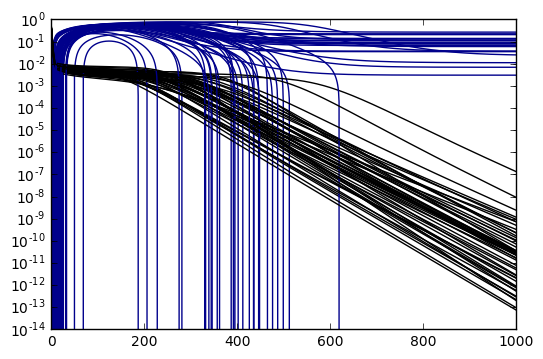

In [122]:
for nrslt in nrslts:
    plot_overlap_dynamics(nrslt['opL'], nrslt['opQRT'])
plt.show()

問い：初期値から，プラトーの長さを予測できるか？？

In [75]:
loss_curve_infos = []
for nrslt in nrslts:
    loss_curve_infos.append(analyze_loss_curve(nrslt['opL'], loss_goal=1e-5))

In [76]:
plens = []
for lci in loss_curve_infos:
    plens.append(lci['plateau_time_info'][1] - lci['plateau_time_info'][0])

In [77]:
# nrslts[i]['opQRT'][0] から， plens[i] を予測する．
x = np.array([nrslt['opQRT'][0].flatten() for nrslt in nrslts])
y = np.array(plens)

In [82]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import matplotlib.cm as cm

In [79]:
# とりあえず可視化してみるか．
pca = PCA(n_components=2)
pca.fit(x)
px = pca.transform(x)

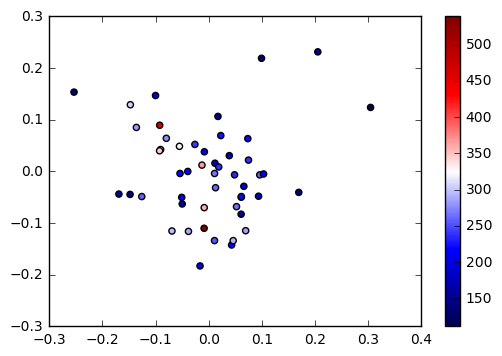

In [80]:
sc = plt.scatter(px[:,0], px[:,1], c=y, cmap=cm.seismic)
plt.colorbar(sc)
plt.show()

In [84]:
# 線形回帰
lr = LinearRegression()
lr.fit(x, y)

/Users/yoshidayuuki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [85]:
pred_y = lr.predict(x)

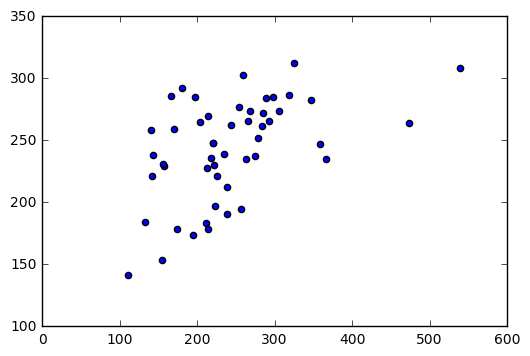

In [87]:
plt.scatter(y, pred_y)
plt.show()

In [92]:
coef = np.array(lr.coef_).reshape(4,4)
print(coef)

[[ 244.438165     14.50754001  -88.69126607   98.69412587]
 [  14.50754001  -50.08102012   27.65913326   58.72886644]
 [ -88.69126607   27.65913326 -428.25219199   65.83584029]
 [  98.69412587   58.72886644   65.83584029   -8.13028468]]


わかること：
Q11>>Q22だとプラトーが伸びる？
T11<<T22 だとプラトーが伸びる？

#### x の前処理として, 全データで T11>T22 となるように行と列を入れ替えることを考える

In [113]:
x_new = []
for row in x:
    mat = np.copy(row.reshape(4,4))
    if mat[2,2] < mat[3,3]:
        mat = mat[[1,0,3,2],:][:,[1,0,3,2]]
    x_new.append(mat.flatten())
x_new = np.array(x_new)

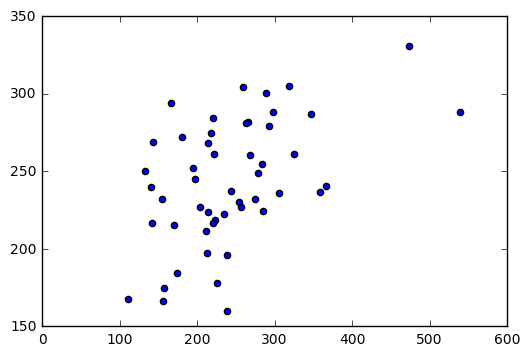

In [118]:
lr = LinearRegression()
lr.fit(x_new, y)
pred_y = lr.predict(x_new)
plt.scatter(y, pred_y)
plt.show()

In [119]:
coef = np.array(lr.coef_).reshape(4,4)
print(coef)

[[  92.45404986   78.27280149  -61.21524729  -44.8038678 ]
 [  78.27280149   31.35774741  176.19228357  179.26784873]
 [ -61.21524729  176.19228357   28.80685579  126.9752658 ]
 [ -44.8038678   179.26784873  126.9752658  -578.10521368]]


**わかったこと**

T11>T22としたが，T22が短いほどプラトーは長くなる．この寄与はとても大きい

#### そもそも T11==T22 にすべきでは？

In [151]:
nrslts = []

In [153]:
nb_iter = 1000
eta = 1.0
lambdas = np.ones(N)
for i in range(10):
    teacher_model = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)
    teacher_model.l[0].W.data = normalize_row(teacher_model.l[0].W.data.astype(np.float64)).astype(np.float32)
    teacher_model.l[1].W.data = np.array([[1, 1]],dtype=np.float32)
    nrslt = calc_opd(N, nb_iter, lambdas, eta, mdl_t=teacher_model, verbose=False) # opd_inf_KM_inf での計算．1次のオーダパラメータのみ考慮．
    nrslts.append(nrslt)

nQRT: [[ 0.95938326  0.05889553 -0.15104996  0.14766708]
 [ 0.05889553  0.84331582 -0.05430151  0.14958824]
 [-0.15104996 -0.05430151  1.         -0.15909915]
 [ 0.14766708  0.14958824 -0.15909915  1.        ]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[1. 1.]
 [1. 1.]]
nT2/nT1:  [[1. 1.]
 [1. 1.]]
QRTcoef:  [1. 1.]
nb_iter: 1000
nQRT: [[ 0.92444576 -0.10081786  0.02880005 -0.02163893]
 [-0.10081786  0.86380428  0.09578821 -0.07998074]
 [ 0.02880005  0.09578821  1.         -0.05614884]
 [-0.02163893 -0.07998074 -0.05614884  1.        ]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[1. 1.]
 [1. 1.]]
nT2/nT1:  [[1. 1.]
 [1. 1.]]
QRTcoef:  [1. 1.]
nb_iter: 1000
nQRT: [[ 1.16234608 -0.08966878  0.1228917  -0.10690526]
 [-0.08966878  0.87254018 -0.05226561  0.06629868]
 [ 0.1228917  -0.05226561  1.         -0.03779377]
 [-0.10690526  0.06629868 -0.03779377  1.        ]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 

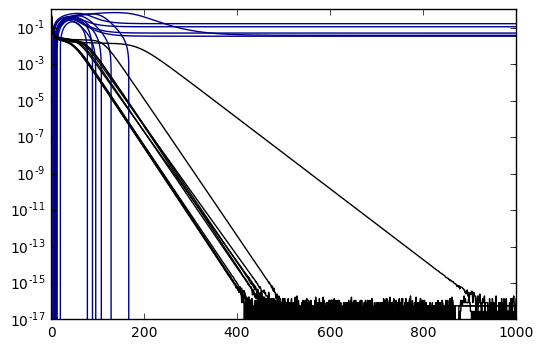

In [154]:
for nrslt in nrslts:
    plot_overlap_dynamics(nrslt['opL'], nrslt['opQRT'])
plt.show()

In [156]:
loss_curve_infos = []
for nrslt in nrslts:
    loss_curve_infos.append(analyze_loss_curve(nrslt['opL'], loss_goal=1e-5))
plens = []
for lci in loss_curve_infos:
    plens.append(lci['plateau_time_info'][1] - lci['plateau_time_info'][0])

In [157]:
# nrslts[i]['opQRT'][0] から， plens[i] を予測する．
x = np.array([nrslt['opQRT'][0].flatten() for nrslt in nrslts])
y = np.array(plens)

In [160]:
# 一応，T11>=T22 が保証されるようにxを整形してx_newとする
x_new = []
for row in x:
    mat = np.copy(row.reshape(4,4))
    if mat[2,2] < mat[3,3]:
        mat = mat[[1,0,3,2],:][:,[1,0,3,2]]
    x_new.append(mat.flatten())
x_new = np.array(x_new)

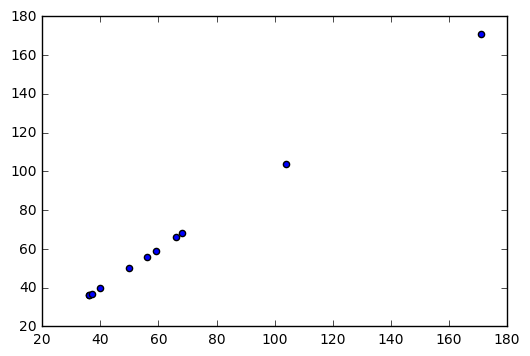

In [161]:
# 線形回帰
lr = LinearRegression()
lr.fit(x_new, y)
pred_y = lr.predict(x_new)
plt.scatter(y, pred_y)
plt.show()

In [162]:
coef = np.array(lr.coef_).reshape(4,4)
print(coef)

[[ 3.00974973e+02  9.41492947e+01 -4.16034590e+01 -7.10803975e+02]
 [-1.39675568e+02 -6.83060685e+02 -3.78440805e+02 -1.09304177e+02]
 [ 5.97425985e+01 -3.98889485e+02  1.83852217e+10 -8.32142620e+02]
 [-6.16357327e+02 -1.04639920e+02 -8.32142620e+02 -3.51129568e+09]]


In [167]:
coef * x_new.std(axis=0).reshape(4,4)

array([[ 19.8761621 ,   9.38279451,  -3.32041601, -56.1035359 ],
       [-13.91988284, -83.58571726, -42.54412056, -13.31204206],
       [  4.7681199 , -44.84295057, 158.00095144, -80.5922242 ],
       [-48.64889149, -12.74398705, -80.5922242 , -20.99974387]])

**教師は全試行で同じにしませんか？（ランダム初期化すら無しで！）**

In [168]:
nrslts = []

In [ ]:
teacher_model = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)
teacher_model.l[0].W.data = normalize_row(teacher_model.l[0].W.data.astype(np.float64)).astype(np.float32)
teacher_model.l[1].W.data = np.array([[1, 1]],dtype=np.float32)

In [202]:
nb_iter = 1000
eta = 1.0
lambdas = np.ones(N)
for i in range(10):
    nrslt = calc_opd(N, nb_iter, lambdas, eta, mdl_t=teacher_model, verbose=False) # opd_inf_KM_inf での計算．1次のオーダパラメータのみ考慮．
    nrslts.append(nrslt)

nQRT: [[ 0.95861132 -0.20576116  0.23741253 -0.0858411 ]
 [-0.20576116  0.90368222  0.02406737 -0.07077326]
 [ 0.23741253  0.02406737  1.00000001 -0.10557912]
 [-0.0858411  -0.07077326 -0.10557912  1.        ]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[1. 1.]
 [1. 1.]]
nT2/nT1:  [[1. 1.]
 [1. 1.]]
QRTcoef:  [1.         1.00000001]
nb_iter: 1000
nQRT: [[ 0.82441359  0.04280448  0.12748317  0.04247649]
 [ 0.04280448  0.92167681 -0.22138588  0.13357048]
 [ 0.12748317 -0.22138588  1.00000001 -0.10557912]
 [ 0.04247649  0.13357048 -0.10557912  1.        ]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[1. 1.]
 [1. 1.]]
nT2/nT1:  [[1. 1.]
 [1. 1.]]
QRTcoef:  [1.         1.00000001]
nb_iter: 1000
nQRT: [[ 0.96905571  0.00756461  0.16852195 -0.11475852]
 [ 0.00756461  1.03840424 -0.14157988 -0.11639428]
 [ 0.16852195 -0.14157988  1.00000001 -0.10557912]
 [-0.11475852 -0.11639428 -0.10557912  1.        ]]
nABC: [[1

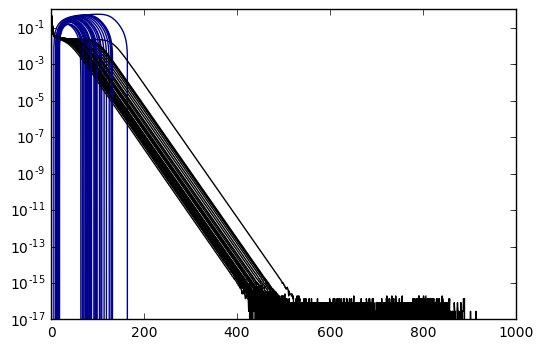

In [203]:
for nrslt in nrslts:
    plot_overlap_dynamics(nrslt['opL'], nrslt['opQRT'])
plt.show()

In [204]:
loss_curve_infos = []
for nrslt in nrslts:
    loss_curve_infos.append(analyze_loss_curve(nrslt['opL'], loss_goal=1e-5))
plens = []
for lci in loss_curve_infos:
    plens.append(lci['plateau_time_info'][1] - lci['plateau_time_info'][0])

In [205]:
# nrslts[i]['opQRT'][0] から， plens[i] を予測する．
x = np.array([nrslt['opQRT'][0].flatten() for nrslt in nrslts])
y = np.array(plens)
x.shape, y.shape

((30, 16), (30,))

In [210]:
# 今回は x[10,11,14,15] は全部同じ値のはずなので，特徴量から除外する．
x = x[:,[0,1,2,3,4,5,6,7,8,9,12,13]]

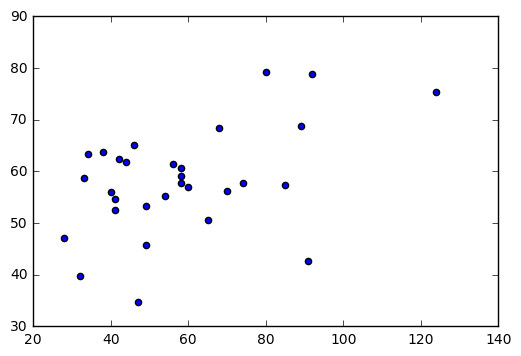

In [211]:
# 線形回帰
lr = LinearRegression()
lr.fit(x, y)
pred_y = lr.predict(x)
plt.scatter(y, pred_y)
plt.show()

In [212]:
coef = np.zeros(16)
coef[[0,1,2,3,4,5,6,7,8,9,12,13]] = np.array(lr.coef_)
coef = coef.reshape(4,4)
print(coef)

[[ 18.00718577  17.09544348   4.56657489  -9.04451811]
 [ 17.09544348 -69.71146308  26.2447575  -16.4060007 ]
 [  4.56657489  26.2447575    0.           0.        ]
 [ -9.04451811 -16.4060007    0.           0.        ]]


**教師は全試行で同じにしませんか？（ランダム初期化すら無しで！）（さらに厳密に直交化して！）**

In [214]:
nrslts = []

In [215]:
teacher_model = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)
teacher_model.l[0].W.data = np.array([[1]+[0]*(N-1), [0, 1]+[0]*(N-2)], dtype=np.float32)
teacher_model.l[1].W.data = np.array([[1, 1]],dtype=np.float32)

In [217]:
nb_iter = 1000
eta = 1.0
lambdas = np.ones(N)
for i in range(10):
    nrslt = calc_opd(N, nb_iter, lambdas, eta, mdl_t=teacher_model, verbose=False) # opd_inf_KM_inf での計算．1次のオーダパラメータのみ考慮．
    nrslts.append(nrslt)

nQRT: [[ 0.75659887 -0.07452559  0.17592958 -0.00110498]
 [-0.07452559  0.85971787 -0.21999499 -0.1854101 ]
 [ 0.17592958 -0.21999499  1.          0.        ]
 [-0.00110498 -0.1854101   0.          1.        ]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[ 1. nan]
 [nan  1.]]
nT2/nT1:  [[ 1. nan]
 [nan  1.]]
QRTcoef:  [1. 1.]
nb_iter: 1000


/Users/yoshidayuuki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/yoshidayuuki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in true_divide
/Users/yoshidayuuki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in true_divide


nQRT: [[ 0.91445734  0.12289668 -0.11234299  0.03087531]
 [ 0.12289668  0.99175806  0.07109642 -0.27334818]
 [-0.11234299  0.07109642  1.          0.        ]
 [ 0.03087531 -0.27334818  0.          1.        ]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[ 1. nan]
 [nan  1.]]
nT2/nT1:  [[ 1. nan]
 [nan  1.]]
QRTcoef:  [1. 1.]
nb_iter: 1000
nQRT: [[ 1.13419191 -0.06087592 -0.07320219 -0.20630814]
 [-0.06087592  1.04727443  0.10051737  0.07475034]
 [-0.07320219  0.10051737  1.          0.        ]
 [-0.20630814  0.07475034  0.          1.        ]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[ 1. nan]
 [nan  1.]]
nT2/nT1:  [[ 1. nan]
 [nan  1.]]
QRTcoef:  [1. 1.]
nb_iter: 1000
nQRT: [[ 1.05893864 -0.03487271  0.07786418 -0.11063851]
 [-0.03487271  0.89271399 -0.04204584  0.01063578]
 [ 0.07786418 -0.04204584  1.          0.        ]
 [-0.11063851  0.01063578  0.          1.        ]]
nABC: [[1. 1. 1. 1.]
 [1.

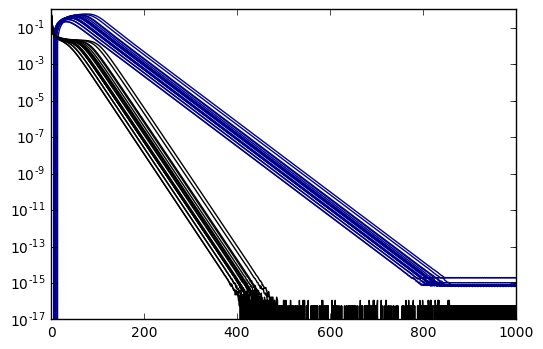

In [218]:
for nrslt in nrslts:
    plot_overlap_dynamics(nrslt['opL'], nrslt['opQRT'])
plt.show()

In [238]:
def plot_R1R2_trajectory(opQRT):
    R11 = opQRT[:,0,2]
    R12 = opQRT[:,0,3]
    R21 = opQRT[:,1,2]
    R22 = opQRT[:,1,3]
    plt.plot(R11, R12, color='r')
    plt.plot(R21, R22, color='r')
    plt.xlim(-0.5, 1.5)
    plt.ylim(-0.5, 1.5)
    plt.grid()
    plt.gca().set_aspect('equal', adjustable='box')

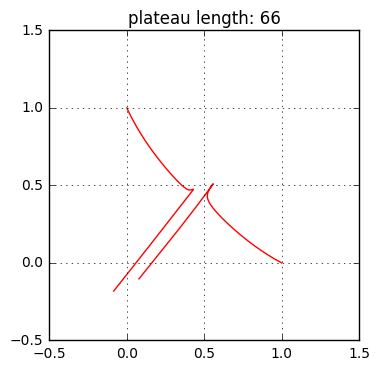

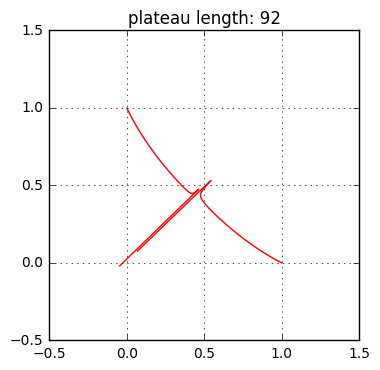

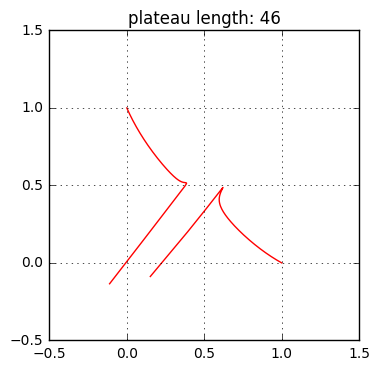

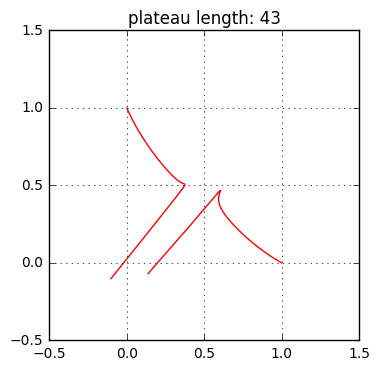

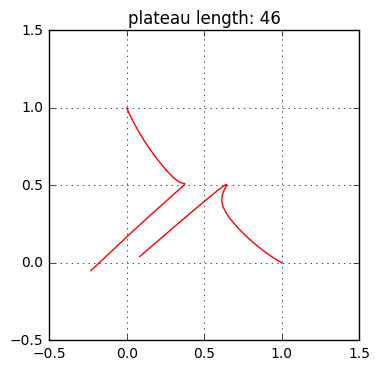

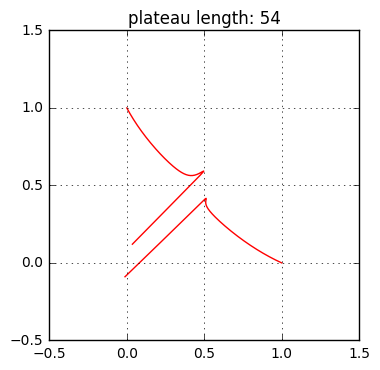

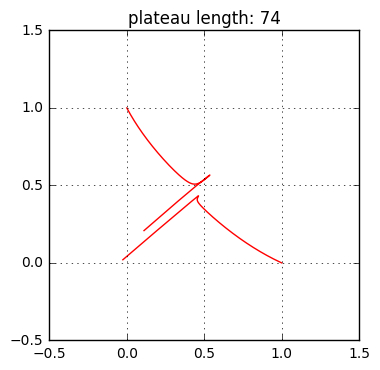

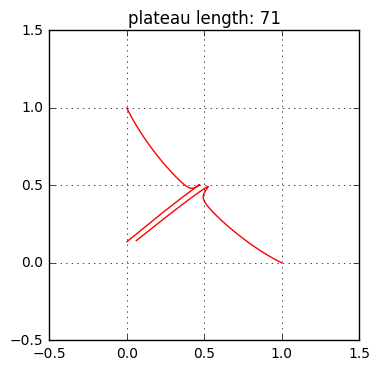

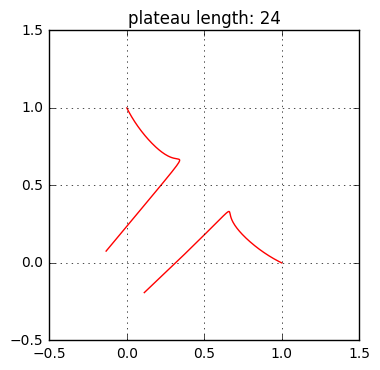

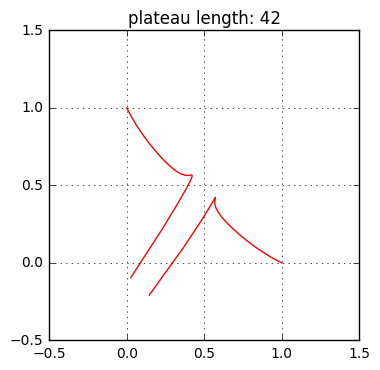

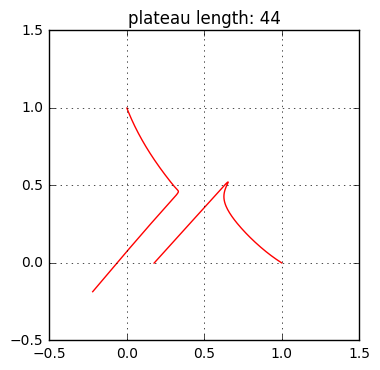

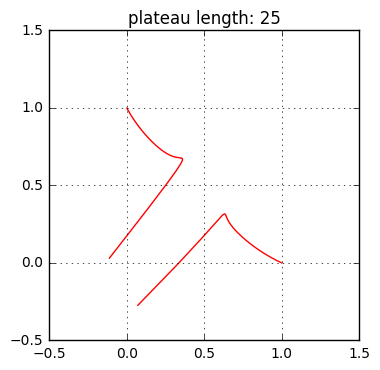

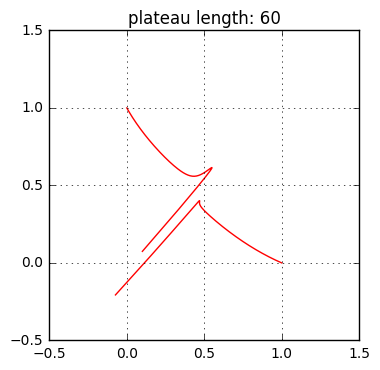

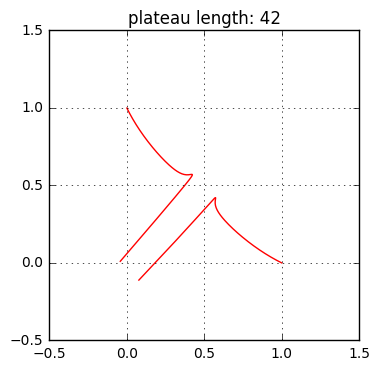

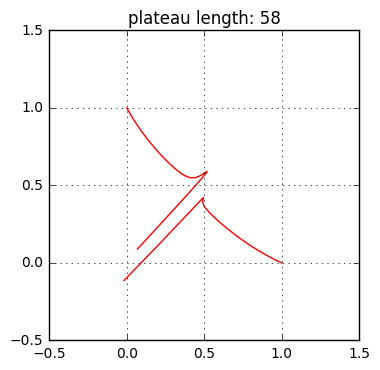

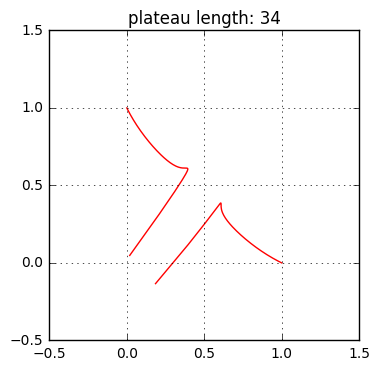

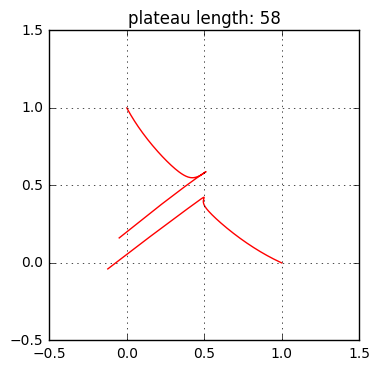

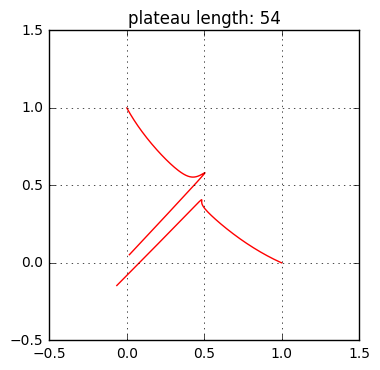

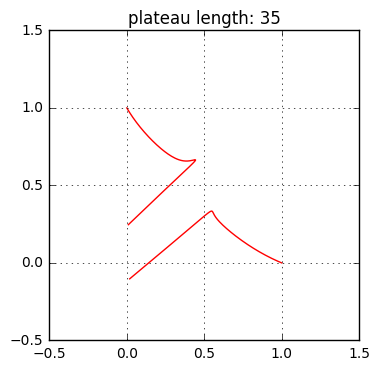

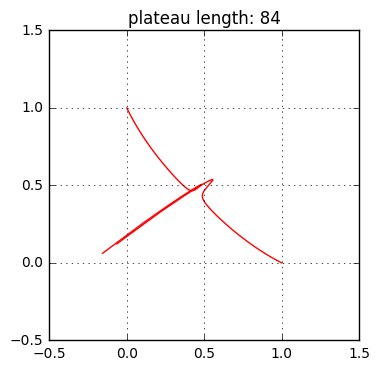

In [239]:
for nrslt in nrslts:
    plt.figure()
    plot_R1R2_trajectory(nrslt['opQRT'])
    plateau_info = analyze_loss_curve(nrslt['opL'])['plateau_time_info']
    plen = plateau_info[1] - plateau_info[0]
    plt.title('plateau length: {}'.format(plen))
plt.show()

わかったこと！

# 初期値の abs(R12 - R11 - R22 + R21) が小さいほどプラトーは長くなりそうだ！

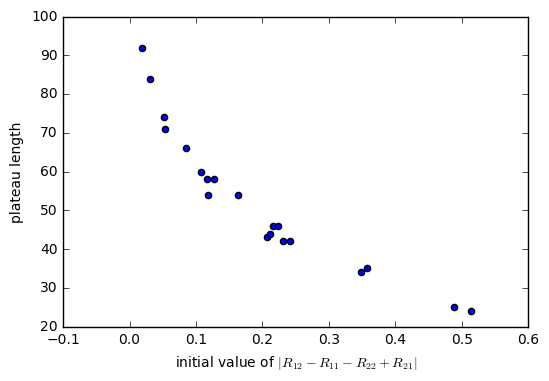

In [253]:
scores = []
plens = []
for nrslt in nrslts:
    _= nrslt['opQRT'][0]
    scores.append(abs(_[0,3] - _[0,2] - _[1,3] + _[1,2]))
    plateau_info = analyze_loss_curve(nrslt['opL'])['plateau_time_info']
    plens.append(plateau_info[1] - plateau_info[0])
plt.scatter(scores, plens)
plt.xlabel('initial value of $|R_{12}-R_{11} - R_{22} + R_{21}|$')
plt.ylabel('plateau length')
plt.show()    

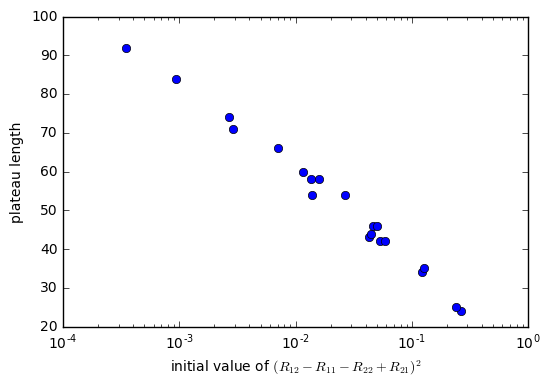

In [255]:
scores = []
plens = []
for nrslt in nrslts:
    _= nrslt['opQRT'][0]
    scores.append((_[0,3] - _[0,2] - _[1,3] + _[1,2])**2)
    plateau_info = analyze_loss_curve(nrslt['opL'])['plateau_time_info']
    plens.append(plateau_info[1] - plateau_info[0])
plt.plot(scores, plens, linestyle='', marker='o')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('initial value of $(R_{12}-R_{11} - R_{22} + R_{21})^2$')
plt.ylabel('plateau length')
plt.show()    

## この理屈は， 教師が厳密に直交でなくても割と成り立つのでは？
教師の初期化を毎回やってみよう．（それも厳密に直交化はせずに）

In [257]:
nrslts = []

In [258]:
nb_iter = 1000
eta = 1.0
lambdas = np.ones(N)
for i in range(10):
    teacher_model = MLP(ls=[N,2,1], nobias=True, act=func_erf2, opt=None)
    teacher_model.l[0].W.data = normalize_row(teacher_model.l[0].W.data.astype(np.float64)).astype(np.float32)
    teacher_model.l[1].W.data = np.array([[1, 1]],dtype=np.float32)
    nrslt = calc_opd(N, nb_iter, lambdas, eta, mdl_t=teacher_model, verbose=False) # opd_inf_KM_inf での計算．1次のオーダパラメータのみ考慮．
    nrslts.append(nrslt)

nQRT: [[ 1.04049353 -0.10421283 -0.0759603  -0.03905338]
 [-0.10421283  0.90419492  0.03925026  0.05606489]
 [-0.0759603   0.03925026  0.99999999 -0.18621433]
 [-0.03905338  0.05606489 -0.18621433  0.99999999]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[1. 1.]
 [1. 1.]]
nT2/nT1:  [[1. 1.]
 [1. 1.]]
QRTcoef:  [1.         0.99999999]
nb_iter: 1000
nQRT: [[ 0.78493414  0.20943179  0.12381851  0.02956173]
 [ 0.20943179  1.0481598  -0.04923835  0.00338444]
 [ 0.12381851 -0.04923835  1.          0.11151   ]
 [ 0.02956173  0.00338444  0.11151     0.99999999]]
nABC: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[1. 1.]
 [1. 1.]]
nT2/nT1:  [[1. 1.]
 [1. 1.]]
QRTcoef:  [1. 1.]
nb_iter: 1000
nQRT: [[ 6.87675296e-01 -6.17308838e-04  9.26699815e-02  1.35472661e-02]
 [-6.17308838e-04  1.02536347e+00  1.34523973e-01  4.09779338e-02]
 [ 9.26699815e-02  1.34523973e-01  9.99999991e-01  1.47917351e-02]
 [ 1.35472661e-02  4.09779338

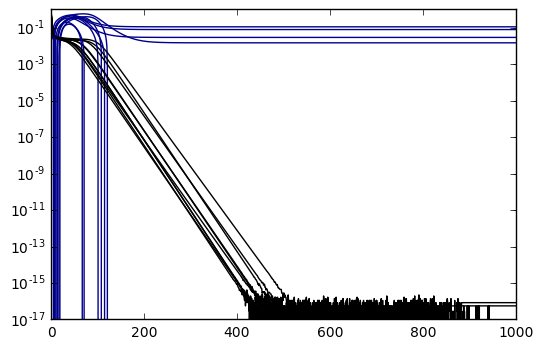

In [259]:
for nrslt in nrslts:
    plot_overlap_dynamics(nrslt['opL'], nrslt['opQRT'])
plt.show()

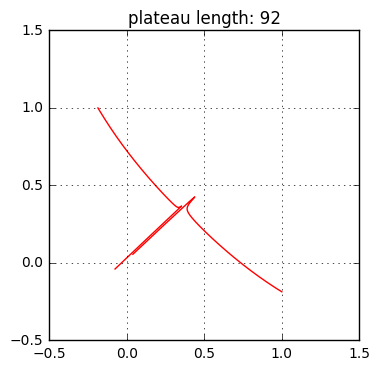

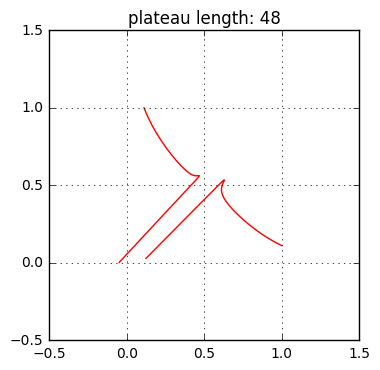

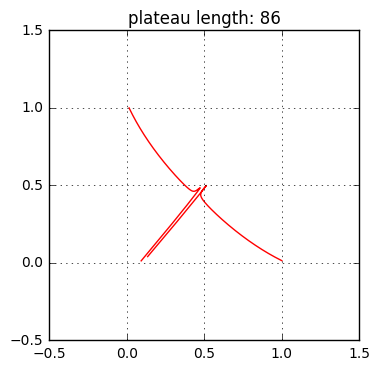

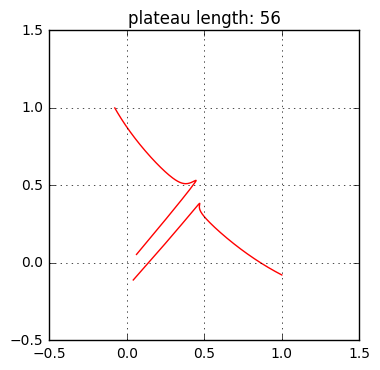

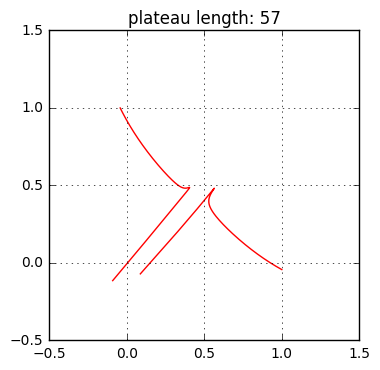

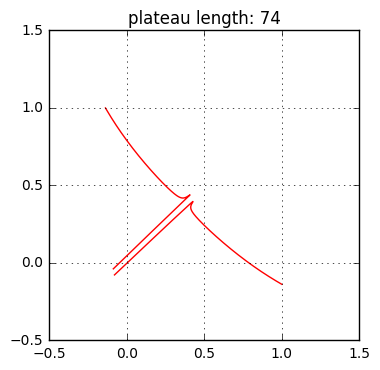

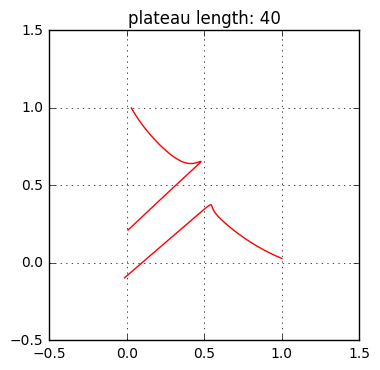

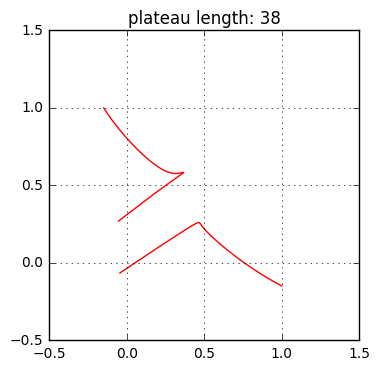

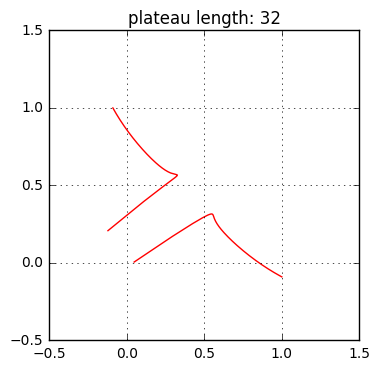

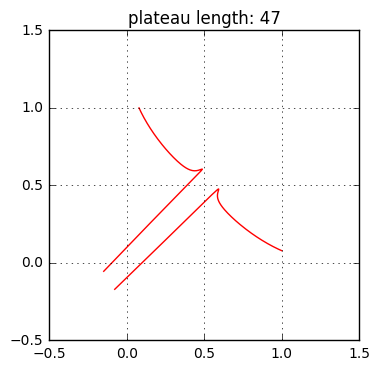

In [260]:
for nrslt in nrslts:
    plt.figure()
    plot_R1R2_trajectory(nrslt['opQRT'])
    plateau_info = analyze_loss_curve(nrslt['opL'])['plateau_time_info']
    plen = plateau_info[1] - plateau_info[0]
    plt.title('plateau length: {}'.format(plen))
plt.show()

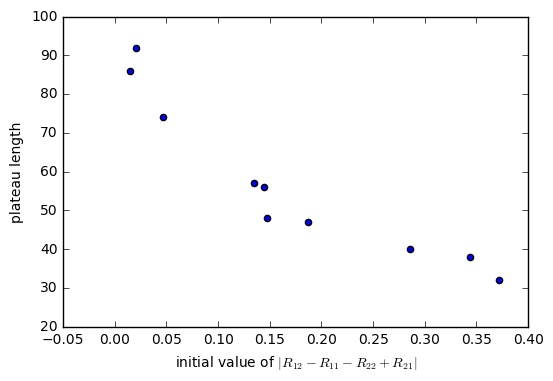

In [261]:
scores = []
plens = []
for nrslt in nrslts:
    _= nrslt['opQRT'][0]
    scores.append(abs(_[0,3] - _[0,2] - _[1,3] + _[1,2]))
    plateau_info = analyze_loss_curve(nrslt['opL'])['plateau_time_info']
    plens.append(plateau_info[1] - plateau_info[0])
plt.scatter(scores, plens)
plt.xlabel('initial value of $|R_{12}-R_{11} - R_{22} + R_{21}|$')
plt.ylabel('plateau length')
plt.show()    

# まとめ：N-2-1 のソフトコミッティ生徒教師学習(活性化はerf(x/√2))を行う場合，プラトーの長さは $|R_{12} - R_{11} - R_{22} + R_{21}|$ の初期値でほとんど説明がつく．

この「特徴量」を見つけるのに一番役に立ったのは plot_R1R2_trajectory であった．可視化ってとても大事．

（絶対値が入っているため，線形回帰では見つけられる見込みがなかった）

## 教師の中間素子数が2より大きい時も，だいたい同様の法則が成立するのでは？
すなわち， $|R_{in} - R_{im} - R_{jn} + R_{jm}|$ の最小値 ($i<j$) ($n<m$) が小さいと，プラトーが長くなる？

In [265]:
nrslts = []

In [268]:
K = 3
M = 3

In [271]:
teacher_model = MLP(ls=[N,M,1], nobias=True, act=func_erf2, opt=None)
teacher_model.l[0].W.data = np.array([[1]+[0]*(N-1), [0, 1]+[0]*(N-2), [0, 0, 1] + [0]*(N-3)], dtype=np.float32)
teacher_model.l[1].W.data = np.array([[1] * M],dtype=np.float32)

In [355]:
# これの実行結果 (nrslts) は nrslts.pkl に保存してある．
%%time
nb_iter = 1000
eta = 1.0
lambdas = np.ones(N)
for i in range(59):
    nrslt = calc_opd(N, nb_iter, lambdas, eta, K=K, M=M, mdl_t=teacher_model, verbose=False) # opd_inf_KM_inf での計算．1次のオーダパラメータのみ考慮．
    nrslts.append(nrslt)

nQRT: [[ 1.04863408 -0.17845931  0.05512214  0.02686256  0.0243601  -0.07781677]
 [-0.17845931  1.10852755 -0.13943817  0.07087125  0.03365039 -0.02842434]
 [ 0.05512214 -0.13943817  1.08542573 -0.02348428 -0.03156393  0.05051485]
 [ 0.02686256  0.07087125 -0.02348428  1.          0.          0.        ]
 [ 0.0243601   0.03365039 -0.03156393  0.          1.          0.        ]
 [-0.07781677 -0.02842434  0.05051485  0.          0.          1.        ]]
nABC: [[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[ 1. nan nan]
 [nan  1. nan]
 [nan nan  1.]]
nT2/nT1:  [[ 1. nan nan]
 [nan  1. nan]
 [nan nan  1.]]
QRTcoef:  [1. 1.]
nb_iter: 1000


/Users/yoshidayuuki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/yoshidayuuki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in true_divide
/Users/yoshidayuuki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in true_divide


nQRT: [[ 1.13609533 -0.0847985   0.01197152  0.03443791  0.09513052 -0.00852209]
 [-0.0847985   1.07860837 -0.14594944  0.16606894  0.12203727 -0.07773061]
 [ 0.01197152 -0.14594944  1.0432953  -0.1778947  -0.12955119 -0.14583205]
 [ 0.03443791  0.16606894 -0.1778947   1.          0.          0.        ]
 [ 0.09513052  0.12203727 -0.12955119  0.          1.          0.        ]
 [-0.00852209 -0.07773061 -0.14583205  0.          0.          1.        ]]
nABC: [[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
sqrt(nT4/nT2):  [[ 1. nan nan]
 [nan  1. nan]
 [nan nan  1.]]
nT2/nT1:  [[ 1. nan nan]
 [nan  1. nan]
 [nan nan  1.]]
QRTcoef:  [1. 1.]
nb_iter: 1000
nQRT: [[ 0.90001658  0.04854923 -0.00162985  0.03601899 -0.12106004 -0.08914419]
 [ 0.04854923  0.97606753  0.05509036 -0.03316401 -0.09389444 -0.07249717]
 [-0.00162985  0.05509036  0.80836042  0.02301369  0.03377774  0.0540073 ]
 [ 0.03601899 -0.03316401  0.

KeyboardInterrupt: 

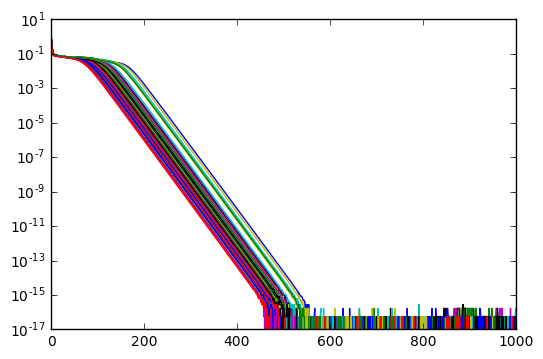

In [357]:
xs = np.arange(len(nrslt['opL']))
for nrslt in nrslts:
    plt.plot(xs, nrslt['opL'])
plt.yscale('log')
plt.show()

$|R_{in} - R_{im} - R_{jn} + R_{jm}|$ の最小値 ($i<j$) ($n<m$) が小さいと，プラトーが長くなる？

→　残念ながらそんなに単純ではないようだ．

In [358]:
len(nrslts)

59

In [17]:
# ロード
import pickle
with open('nrslts.pkl', 'rb') as f:
    nrslts = pickle.load(f)
# セーブ．
#     import pickle
#     with open('nrslts.pkl', 'wb') as f:
#         pickle.dump(nrslts, f)

In [21]:
K = 3
M = 3

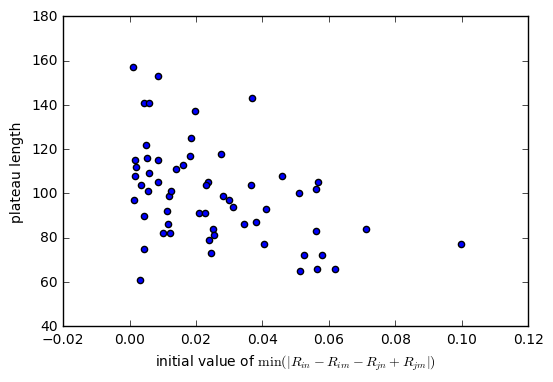

In [24]:
scores = []
plens = []
for nrslt in nrslts:
    R = nrslt['opQRT'][0][:K, K:]
    subscore = []
    for i in range(K):
        for j in range(i):
            for n in range(M):
                for m in range(n):
                    subscore.append(abs(R[i,n] - R[i,m] - R[j,n] + R[j,m]))
    score = min(subscore)
    scores.append(score)
    plateau_info = analyze_loss_curve(nrslt['opL'])['plateau_time_info']
    plens.append(plateau_info[1] - plateau_info[0])
plt.scatter(scores, plens)
plt.xlabel('initial value of $\min(|R_{in}-R_{im} - R_{jn} + R_{jm}|)$')
plt.ylabel('plateau length')
plt.show()    

In [25]:
def plot_R1R2R3_trajectory(opQRT, opL=None):
    R = opQRT[:,:K,K:]
    # R の x1+x2+x3=0 平面への正射影を計算する． 
    trans_mat = np.array([[0, 1], [-np.sqrt(3)/2, -0.5], [np.sqrt(3)/2, -0.5]])
    pR = np.dot(R, trans_mat)
    assert(pR.shape == (len(R), 3, 2))
    plt.plot(pR[:,0,0], pR[:,0,1], color='r')
    plt.plot(pR[:,1,0], pR[:,1,1], color='r')
    plt.plot(pR[:,2,0], pR[:,2,1], color='r')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.grid()
    plt.gca().set_aspect('equal', adjustable='box')
    
    if opL is not None:
        _ = analyze_loss_curve(opL)
        if 'plateau_time_info' in _:
            t = _['plateau_time_info'][0]
            # プラトー突入時刻 t における位置にマーカーを記す．
            plt.scatter(pR[t,:,0], pR[t,:,1])

/Users/yoshidayuuki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


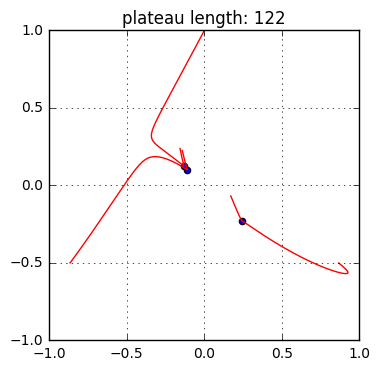

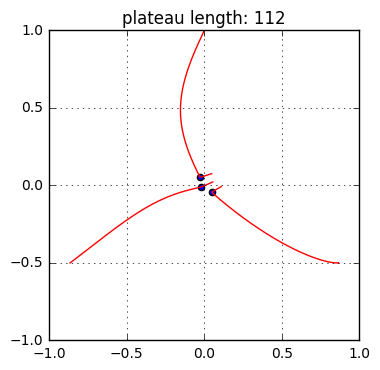

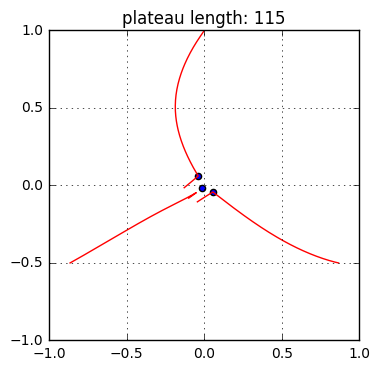

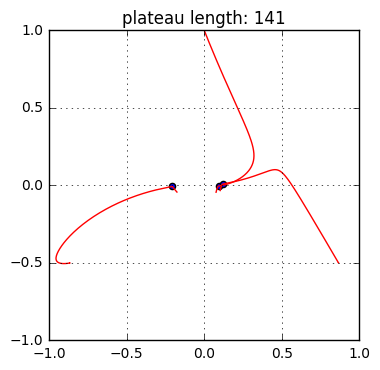

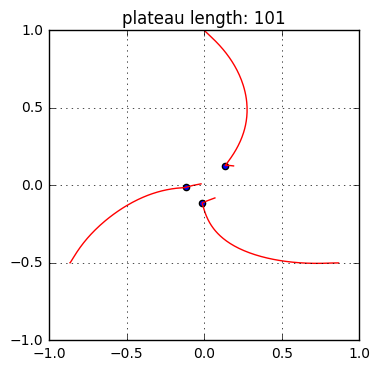

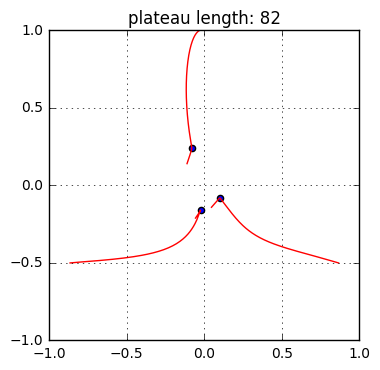

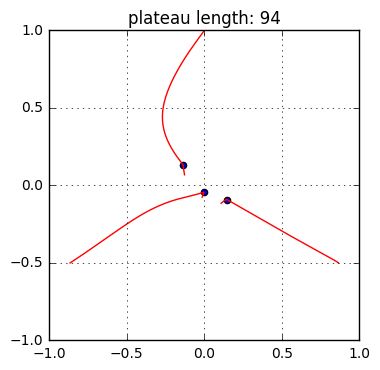

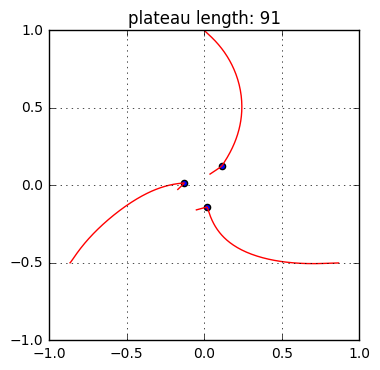

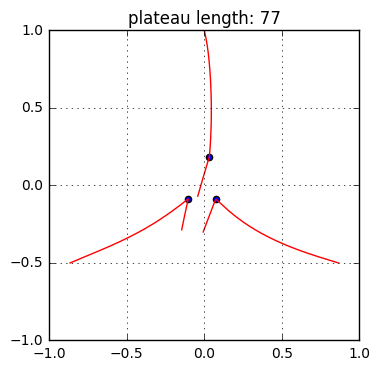

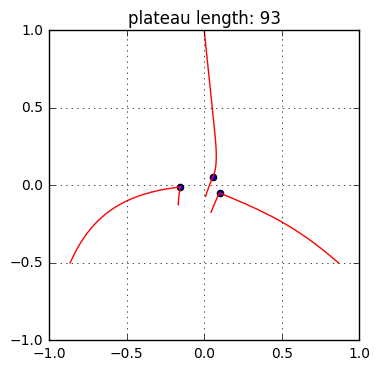

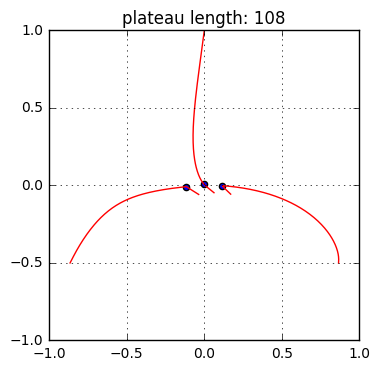

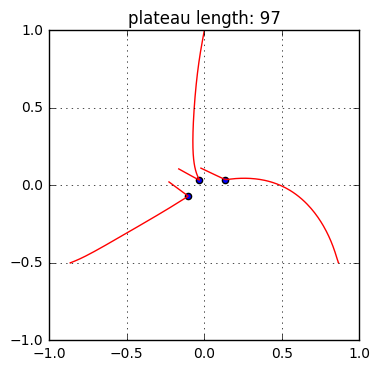

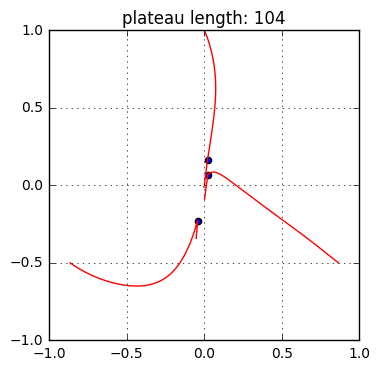

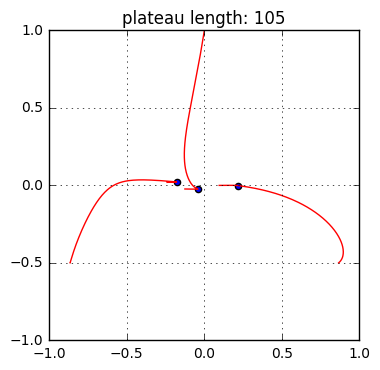

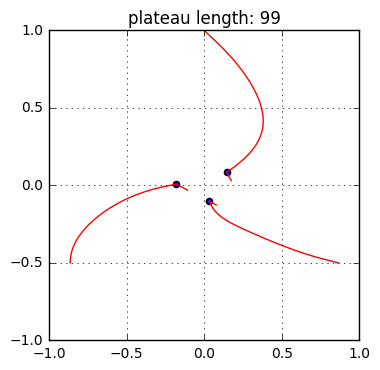

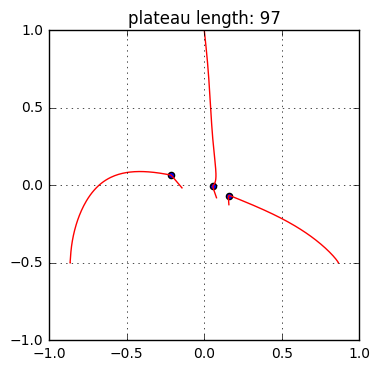

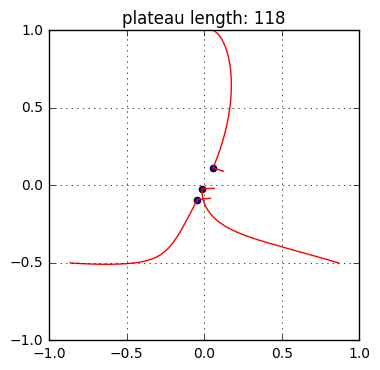

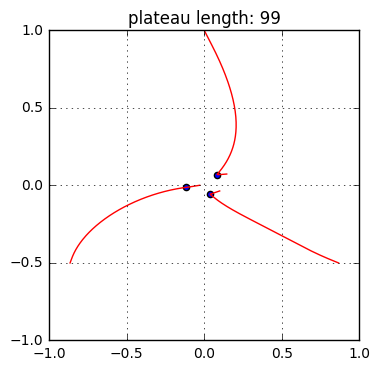

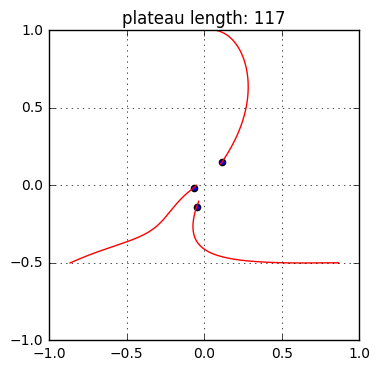

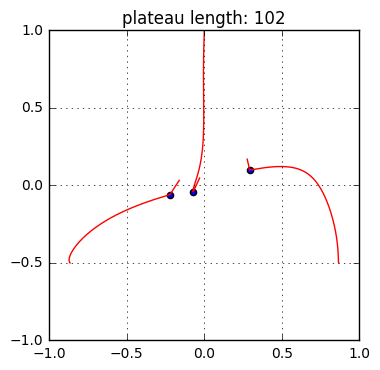

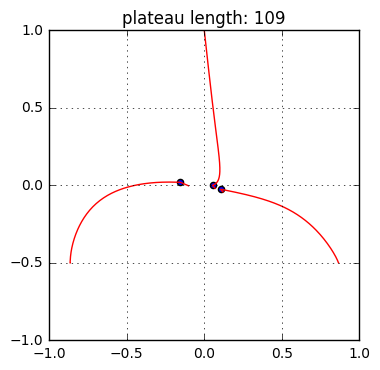

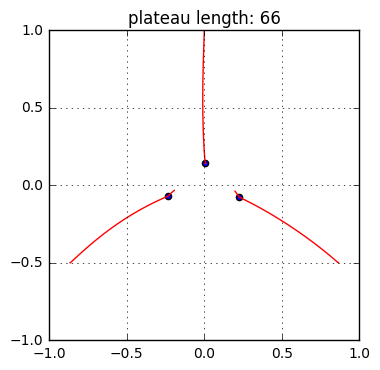

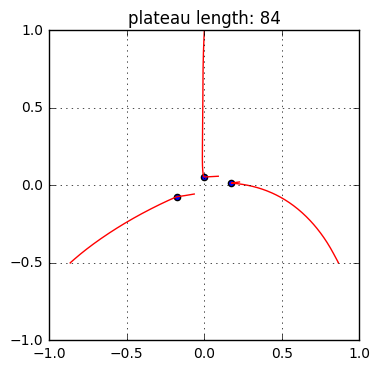

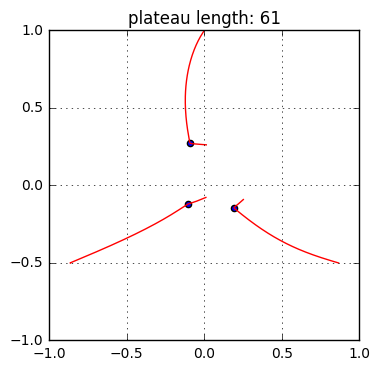

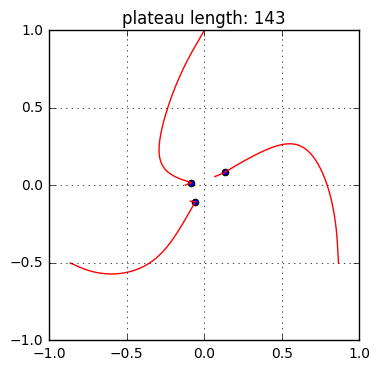

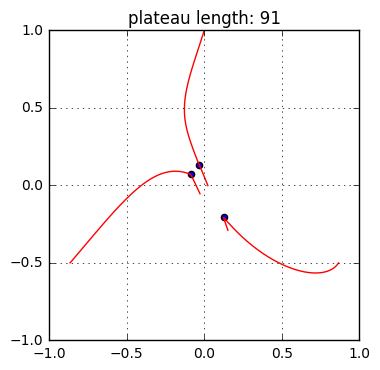

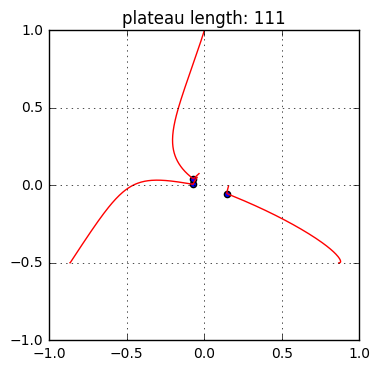

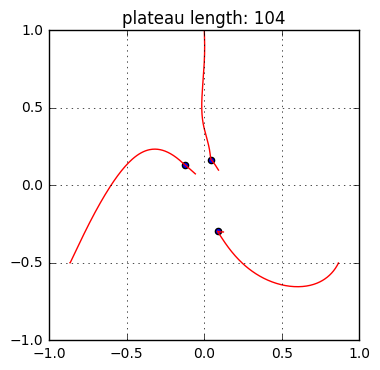

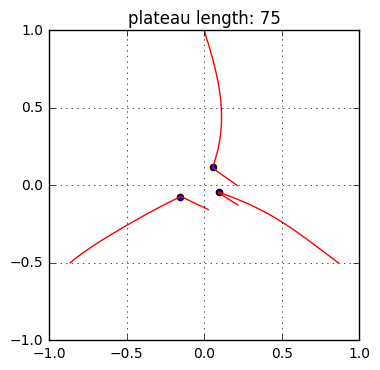

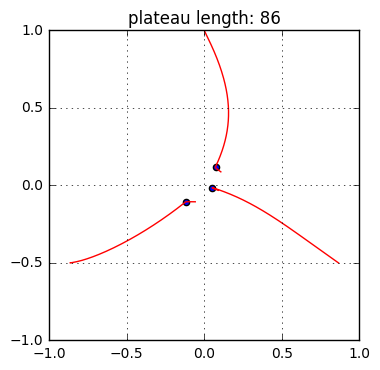

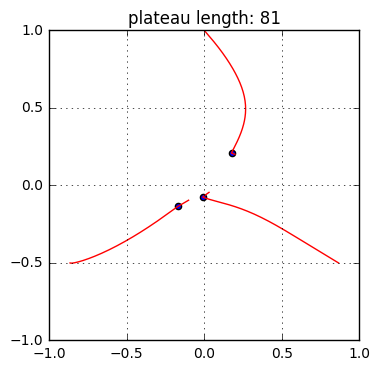

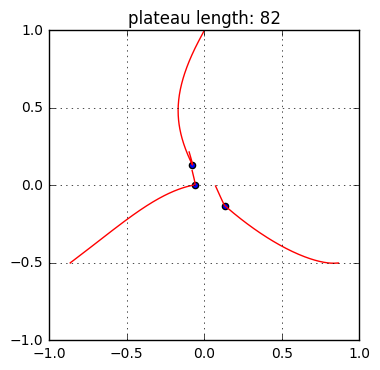

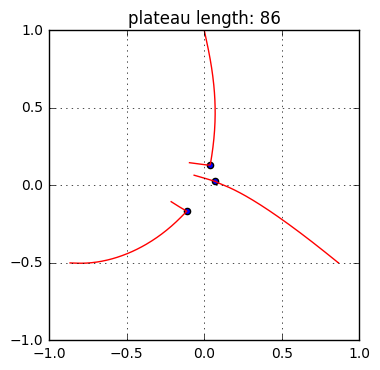

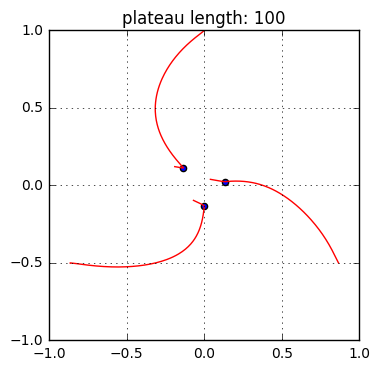

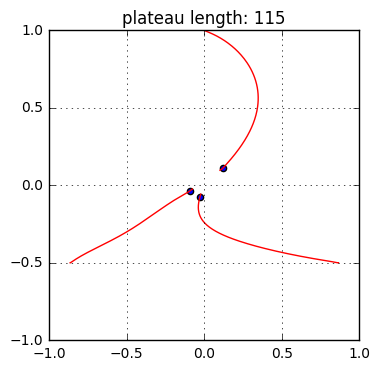

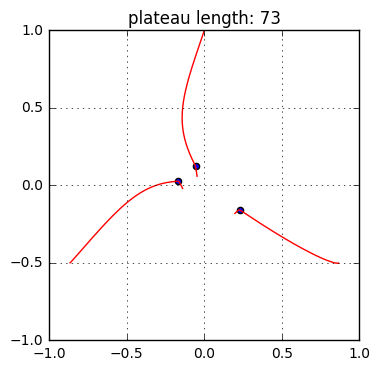

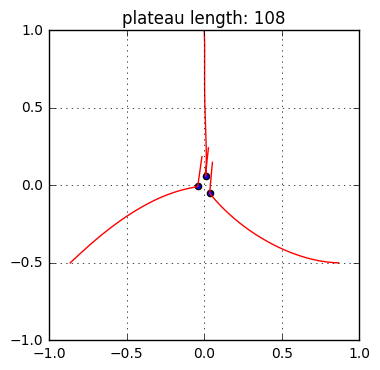

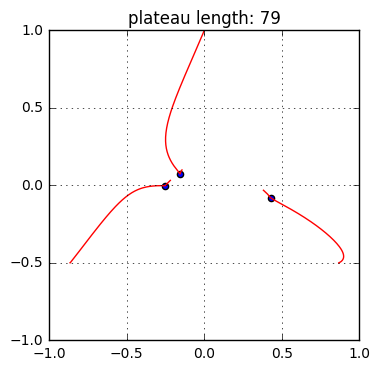

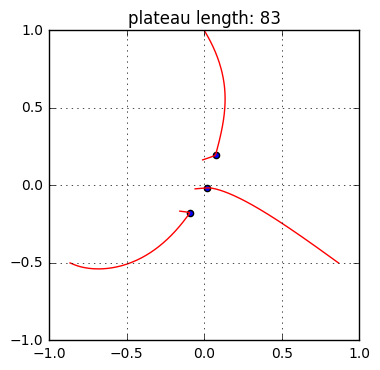

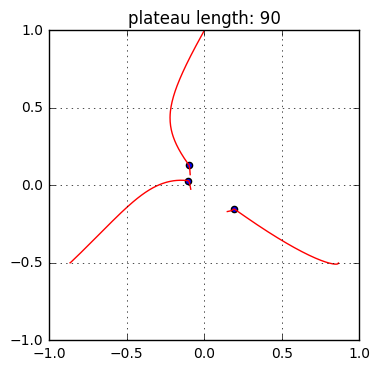

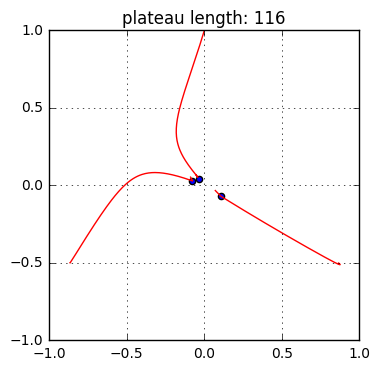

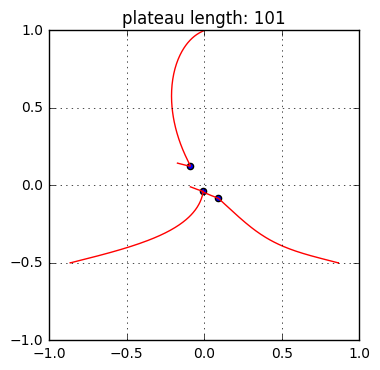

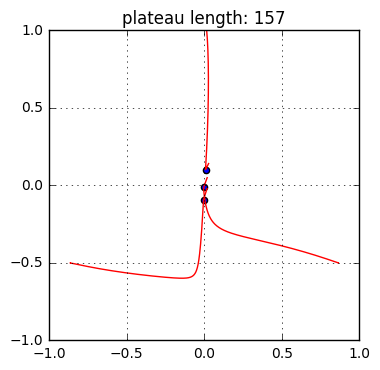

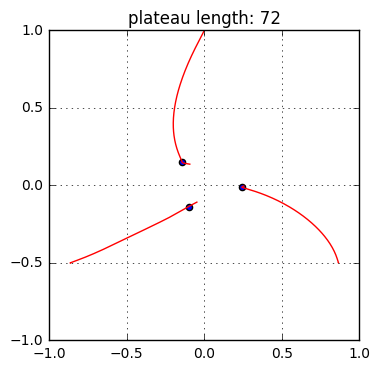

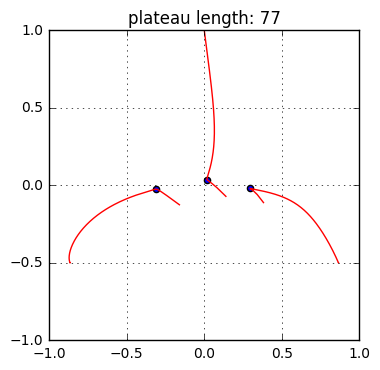

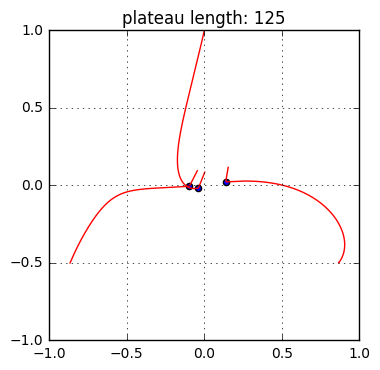

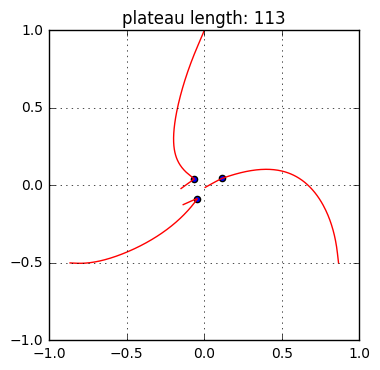

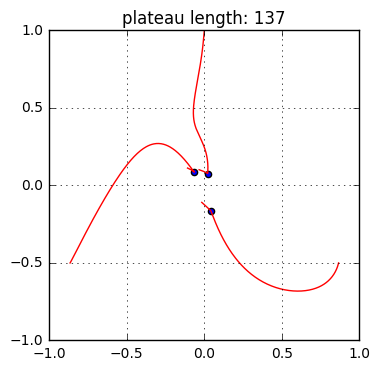

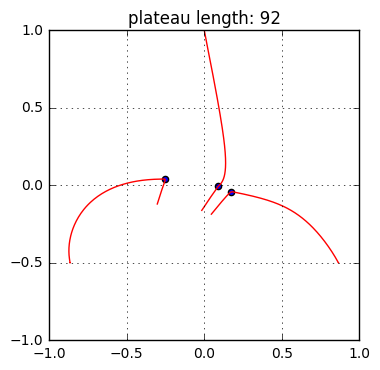

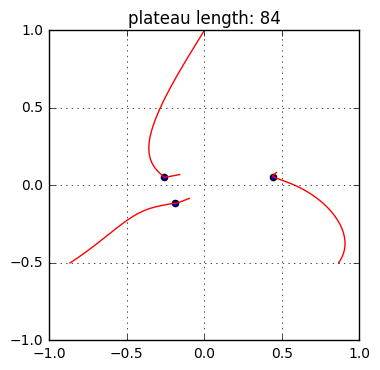

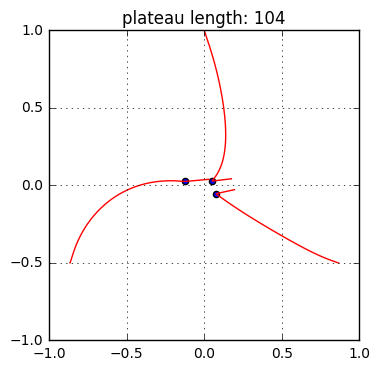

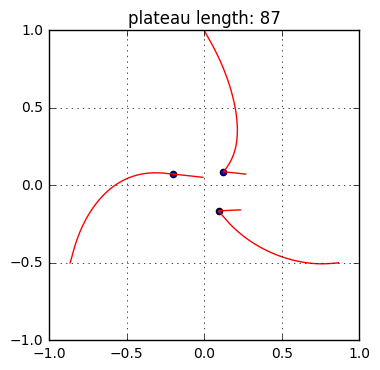

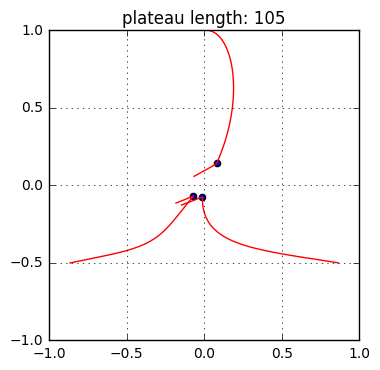

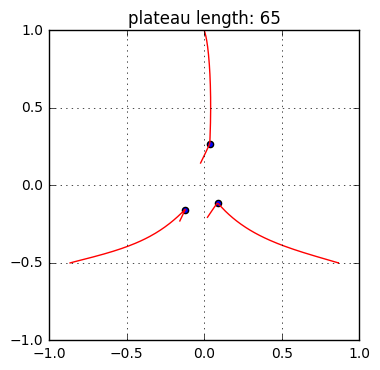

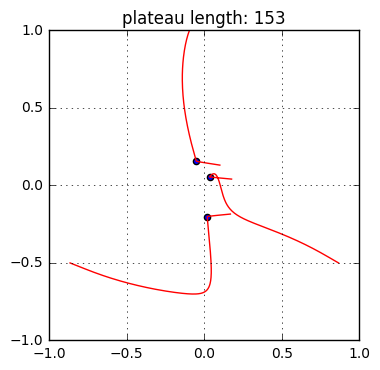

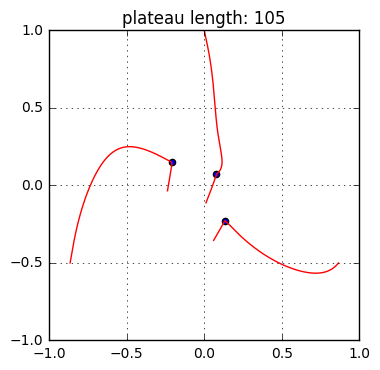

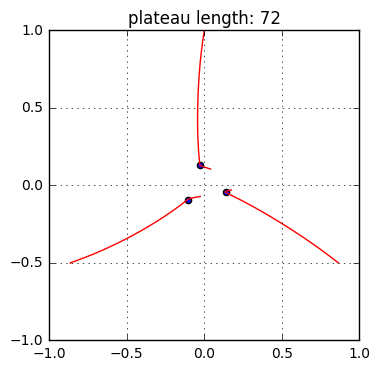

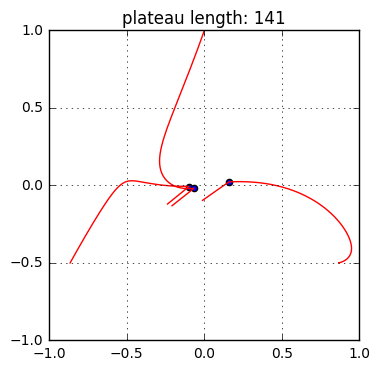

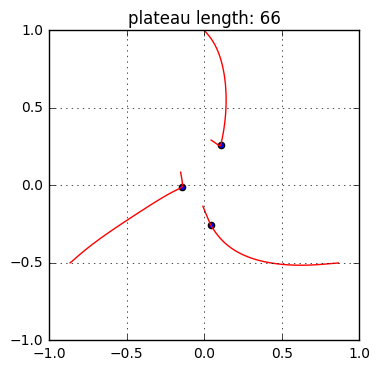

In [26]:
for nrslt in nrslts:
    plt.figure()
    plot_R1R2R3_trajectory(nrslt['opQRT'], nrslt['opL'])
    plateau_info = analyze_loss_curve(nrslt['opL'])['plateau_time_info']
    plen = plateau_info[1] - plateau_info[0]
    plt.title('plateau length: {}'.format(plen))
plt.show()

「この射影された平面上での一番近い二点間距離」がプラトー長さを決めていそうだ．

（まずプラトーに向かって，これらの3点がおよそ平均0になるように並行移動するようだ．そして，プラトーに入る．）

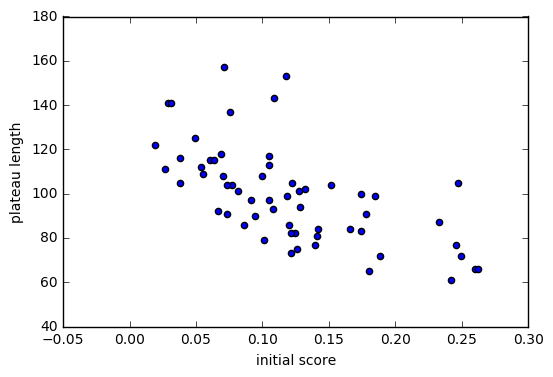

In [27]:
scores = []
plens = []
for nrslt in nrslts:
    R = nrslt['opQRT'][:,:K,K:]
    # R の x1+x2+x3=0 平面への正射影を計算する． 
    trans_mat = np.array([[0, 1], [-np.sqrt(3)/2, -0.5], [np.sqrt(3)/2, -0.5]])
    pR = np.dot(R, trans_mat)
    assert(pR.shape == (len(R), 3, 2))
    dist = np.sort(np.array([
        np.linalg.norm(pR[0,0,:] - pR[0,1,:]),
        np.linalg.norm(pR[0,1,:] - pR[0,2,:]),
        np.linalg.norm(pR[0,2,:] - pR[0,0,:]),
    ])) # 3点間距離（3通り）がソートされて格納されている
    score = np.dot(dist, [1, 0, 0])
    scores.append(score)
    plateau_info = analyze_loss_curve(nrslt['opL'])['plateau_time_info']
    plen = plateau_info[1] - plateau_info[0]    
    plens.append(plen)
plt.scatter(scores, plens)
plt.xlabel('initial score')
plt.ylabel('plateau length')
plt.show()   

K=M=2 の時ほど綺麗ではないが，一次的な指標としてはまあ良さそう．

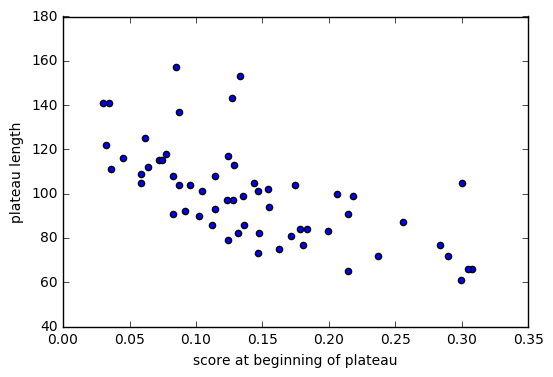

In [31]:
scores = []
plens = []
for nrslt in nrslts:
    R = nrslt['opQRT'][:,:K,K:]
    # R の x1+x2+x3=0 平面への正射影を計算する． 
    trans_mat = np.array([[0, 1], [-np.sqrt(3)/2, -0.5], [np.sqrt(3)/2, -0.5]])
    pR = np.dot(R, trans_mat)
    assert(pR.shape == (len(R), 3, 2))
    plateau_info = analyze_loss_curve(nrslt['opL'])['plateau_time_info']
    dist = np.sort(np.array([
        np.linalg.norm(pR[plateau_info[0],0,:] - pR[plateau_info[0],1,:]),
        np.linalg.norm(pR[plateau_info[0],1,:] - pR[plateau_info[0],2,:]),
        np.linalg.norm(pR[plateau_info[0],2,:] - pR[plateau_info[0],0,:]),
    ])) # 3点間距離（3通り）がソートされて格納されている
    score = np.dot(dist, [1, 0, 0])
    scores.append(score)
    plen = plateau_info[1] - plateau_info[0]    
    plens.append(plen)
plt.scatter(scores, plens)
plt.xlabel('score at beginning of plateau')
plt.ylabel('plateau length')
plt.show()   

K=M=2 の時ほど綺麗ではないが，一次的な指標としてはまあ良さそう．

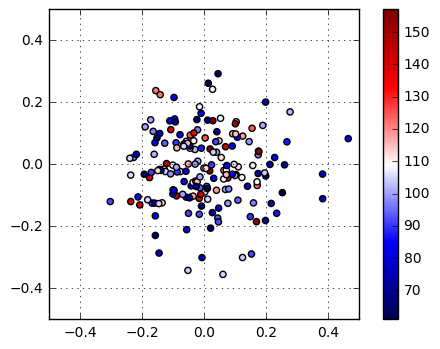

In [364]:
# 射影された平面上での初期位置とプラトー長の関係をプロットしてみよう
prs = []
plens = []
for nrslt in nrslts:
    R = nrslt['opQRT'][:,:K,K:]
    # R の x1+x2+x3=0 平面への正射影を計算する． 
    trans_mat = np.array([[0, 1], [-np.sqrt(3)/2, -0.5], [np.sqrt(3)/2, -0.5]])
    pR = np.dot(R, trans_mat)
    assert(pR.shape == (len(R), 3, 2))
    plateau_info = analyze_loss_curve(nrslt['opL'])['plateau_time_info']
    plen = plateau_info[1] - plateau_info[0] 
    for i in range(3):
        prs.append(pR[0,i,:])
        plens.append(plen)

prs = np.array(prs)
plens = np.array(plens)

sc = plt.scatter(prs[:,0], prs[:,1], c=plens, cmap=cm.seismic)
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(sc)
plt.show()

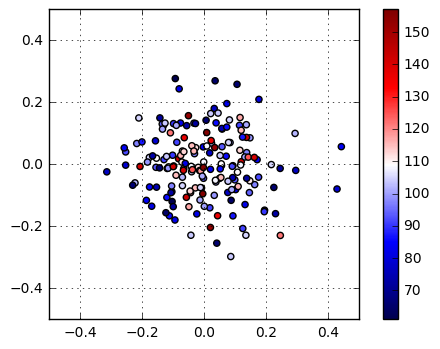

In [371]:
# 射影された平面上での「プラトー開始位置」とプラトー長の関係をプロットしてみよう
prs = []
plens = []
for nrslt in nrslts:
    R = nrslt['opQRT'][:,:K,K:]
    # R の x1+x2+x3=0 平面への正射影を計算する． 
    trans_mat = np.array([[0, 1], [-np.sqrt(3)/2, -0.5], [np.sqrt(3)/2, -0.5]])
    pR = np.dot(R, trans_mat)
    assert(pR.shape == (len(R), 3, 2))
    plateau_info = analyze_loss_curve(nrslt['opL'])['plateau_time_info']
    plen = plateau_info[1] - plateau_info[0] 
    for i in range(3):
        prs.append(pR[plateau_info[0],i,:])
        plens.append(plen)

prs = np.array(prs)
plens = np.array(plens)

sc = plt.scatter(prs[:,0], prs[:,1], c=plens, cmap=cm.seismic)
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(sc)
plt.show()

一般化すると，2つのRの [1,1,...,1] 方向の直線同士が近いペアが存在していると，プラトーが顕著に出ると考えて良さそう．

**中間次元が 20 とかあると，そういうペアが生じづらくなる・・・？（少なくとも，試行ごとのバラツキは減りそう．つまり，プラトーに引っかかるかどうかが決定論的に変化してくる）** いや嘘かも． (K-1)次元空間中のK点のうちの2点間距離の最小．